# Exploratory Data Analysis (EDA) of SWE-Bench Verified Annotation Data

To determine which instances of SWE-Bench Verified are to be moved into the train- and which into the test-split and to develop the methodology for doing so, we will make use of the SWE-Bench Verified annotation data [provided by OpenAI.](https://openai.com/index/introducing-swe-bench-verified/)

## Get annotation data for SWE-Bench Verified samples

In [136]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

In [2]:
annotation_data = pd.read_csv('swe-bench-annotation-results/samples_with_3_annotations_public.csv')
ensembled_annotation_data = pd.read_csv('swe-bench-annotation-results/ensembled_annotations_public.csv')

In [5]:
annotation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5097 entries, 0 to 5096
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   instance_id                 5097 non-null   object 
 1   user_id                     5097 non-null   int64  
 2   difficulty                  5096 non-null   object 
 3   difficulty_notes            5077 non-null   object 
 4   underspecified              5093 non-null   float64
 5   underspecified_notes        5096 non-null   object 
 6   false_negative              5092 non-null   float64
 7   false_negative_notes        5095 non-null   object 
 8   other_major_issues          5068 non-null   float64
 9   other_notes                 328 non-null    object 
 10  annotator_confidence        5097 non-null   int64  
 11  claimed_at                  5097 non-null   object 
 12  updated_at                  5097 non-null   object 
 13  submitted_at                5097 

In [6]:
ensembled_annotation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   instance_id                             1699 non-null   object 
 1   underspecified                          1699 non-null   float64
 2   underspecified_notes                    1699 non-null   object 
 3   false_negative                          1699 non-null   float64
 4   false_negative_notes                    1699 non-null   object 
 5   other_major_issues                      1699 non-null   float64
 6   other_notes                             203 non-null    object 
 7   difficulty                              1699 non-null   object 
 8   underspecified_decided_by               1699 non-null   int64  
 9   false_negative_decided_by               1699 non-null   int64  
 10  other_major_issues_decided_by           1699 non-null   int6

The ensembled annotation data file contains the annotations aggregate to an `instance_id` level with respect to the 1699 instance ids from SWE-Bench that they investigated. The data are aggregated by taking the maximum value, according to their blogpost. Let's quickly check this qualitatively.

In [3]:
ensembled_annotation_data[['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
0,astropy__astropy-11693,1.0,3.0,15 min - 1 hour,0.0
1,astropy__astropy-12544,0.0,3.0,1-4 hours,0.0
2,astropy__astropy-12825,1.0,2.0,1-4 hours,0.0
3,astropy__astropy-12842,1.0,2.0,1-4 hours,0.0
4,astropy__astropy-12880,1.0,3.0,<15 min fix,0.0
...,...,...,...,...,...
1694,sympy__sympy-24539,0.0,1.0,<15 min fix,0.0
1695,sympy__sympy-24562,0.0,0.0,<15 min fix,0.0
1696,sympy__sympy-24661,0.0,0.0,15 min - 1 hour,0.0
1697,sympy__sympy-24723,1.0,0.0,<15 min fix,0.0


In [16]:
annotation_data[annotation_data['instance_id'] == 'astropy__astropy-12891'][['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
15,astropy__astropy-12891,2.0,3.0,15 min - 1 hour,0.0
16,astropy__astropy-12891,1.0,2.0,1-4 hours,0.0
17,astropy__astropy-12891,0.0,0.0,1-4 hours,0.0


For the samples we checked, this seems to hold up. We will this continue by just looking at the aggregated dataset.

In [4]:
del annotation_data

In [5]:
ensembled_annotation_data = ensembled_annotation_data[ensembled_annotation_data['filter_out'] == False]

In [6]:
ensembled_annotation_data

,instance_id,underspecified,underspecified_notes,false_negative,false_negative_notes,other_major_issues,other_notes,difficulty,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
6,astropy__astropy-12907,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...,0.0,NaN,15 min - 1 hour,75,75,75,"[75, 28]",majority,False
9,astropy__astropy-13033,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...,0.0,NaN,15 min - 1 hour,61,61,13,"[13, 17]",majority,False
15,astropy__astropy-13236,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...,0.0,NaN,15 min - 1 hour,71,71,71,[71],median,False
18,astropy__astropy-13398,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...,0.0,NaN,1-4 hours,12,12,12,"[12, 62]",majority,False
20,astropy__astropy-13453,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...,0.0,NaN,15 min - 1 hour,67,67,67,"[61, 28]",majority,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,sympy__sympy-24443,1.0,The `_check_homomorphism` function is broken f...,0.0,The test patch tests the code raising error in...,0.0,NaN,15 min - 1 hour,28,28,28,"[28, 9, 12]",majority,False
1694,sympy__sympy-24539,0.0,The issue is crystal clear in the ticket. It s...,1.0,The tests specifically check whether the `as_e...,0.0,NaN,<15 min fix,7,43,7,"[7, 44, 43]",majority,False
1695,sympy__sympy-24562,0.0,The issue raises a bug where the output of `Ra...,0.0,"The tests check that the value of `Rational(p,...",0.0,NaN,<15 min fix,65,65,65,"[13, 7]",majority,False
1696,sympy__sympy-24661,0.0,The ticket is very clear. The issue is that th...,0.0,The tests are testing all the relational possi...,0.0,NaN,15 min - 1 hour,7,7,7,"[7, 10]",majority,False


We note that of the samples that 539 samples remain. That means there are still 39 more than ended up in the final SWE-Bench. The authors state that they attempt to maximize the amount of difficult samples present and then randomly sample the rest. Thus we will need to use external `instance_id` from the actual dataset to get the annotation data for the dataset.

In [7]:
swe_verified_tasks = open('conf/swe_verified_tasks.txt', mode='r').read().splitlines()

In [8]:
ensembled_annotation_data = ensembled_annotation_data[ensembled_annotation_data['instance_id'].isin(swe_verified_tasks)]

In [12]:
ensembled_annotation_data[['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
6,astropy__astropy-12907,1.0,0.0,15 min - 1 hour,0.0
9,astropy__astropy-13033,1.0,1.0,15 min - 1 hour,0.0
15,astropy__astropy-13236,1.0,0.0,15 min - 1 hour,0.0
18,astropy__astropy-13398,0.0,0.0,1-4 hours,0.0
20,astropy__astropy-13453,0.0,0.0,15 min - 1 hour,0.0
...,...,...,...,...,...
1688,sympy__sympy-24213,1.0,0.0,15 min - 1 hour,0.0
1692,sympy__sympy-24443,1.0,0.0,15 min - 1 hour,0.0
1694,sympy__sympy-24539,0.0,1.0,<15 min fix,0.0
1695,sympy__sympy-24562,0.0,0.0,<15 min fix,0.0


## Explore annotation data for SWE-Bench Verified samples

## Collect resolution metadata

We want to know which samples were solved by how many approaches and by which, we can take this into account when deciding how we construct the train-test splits.

In [110]:
path_to_coding_dir = '/'.join(os.getcwd().split('/')[0:-1])
path_to_swe_bench_verified_experiments = 'overall-swe-bench-leaderboard-data/evaluation/verified'
swe_bench_verified_resolution_data = []

In [111]:
for instance in swe_verified_tasks:
    swe_bench_verified_resolution_data.append({'instance_id': instance, 'was_resolved': False, 'times_solved': 0, 'solved_by': [], 'unsolved_by': []})

In [112]:
swe_bench_verified_resolution_data = pd.DataFrame(swe_bench_verified_resolution_data)

In [113]:
for dirpath, dirnames, filenames in os.walk(path_to_swe_bench_verified_experiments):
    if 'results' in dirpath:
        # We are in the deepest subdirectory for this approach, the results are located here
        approach_slug = dirpath.split('/')[-2]
        
        with open(os.path.join(dirpath, 'results.json'), 'r') as f:
            results = json.loads(f.read())
            resolved_instances = results['resolved']
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'was_resolved'] = True
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'times_solved'] += 1
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'solved_by'].apply(lambda x: x.append(approach_slug))
            swe_bench_verified_resolution_data.loc[~swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'unsolved_by'].apply(lambda x: x.append(approach_slug))

In [114]:
swe_bench_verified_resolution_data.to_json(os.path.join(os.getcwd(), 'swe_bench_verified_resolution_data.json'), indent=4, orient='records', force_ascii=False)

## Explore results and develop dataset splitting procedure

In [14]:
swe_bench_verified_resolution_data = json.loads(open(os.path.join(os.getcwd(), 'swe_bench_verified_resolution_data.json')).read())

In [17]:
swe_bench_verified_resolution_data = pd.DataFrame(swe_bench_verified_resolution_data)

In [18]:
swe_bench_verified_resolution_data.was_resolved.value_counts()

was_resolved
True     390
False    110
Name: count, dtype: int64

In [116]:
swe_bench_verified_resolution_data.times_solved.value_counts()

times_solved
0     110
1      31
2      28
4      25
3      18
21     16
7      15
27     15
14     14
15     14
5      13
10     13
17     12
18     12
8      12
6      12
19     12
26     11
12     11
13     11
23     10
30      9
31      9
28      9
22      8
11      8
29      7
25      7
20      7
16      7
24      6
9       6
32      2
Name: count, dtype: int64

In [117]:
swe_bench_verified_resolution_data[swe_bench_verified_resolution_data['times_solved'] == 1]

,instance_id,was_resolved,times_solved,solved_by,unsolved_by
2,astropy__astropy-13236,True,1,[20240824_gru],[20240721_amazon-q-developer-agent-20240719-de...
11,astropy__astropy-14369,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],[20240721_amazon-q-developer-agent-20240719-de...
14,astropy__astropy-14598,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],[20240721_amazon-q-developer-agent-20240719-de...
45,django__django-11299,True,1,[20241025_composio_swekit],[20240721_amazon-q-developer-agent-20240719-de...
77,django__django-12273,True,1,[20241025_composio_swekit],[20240721_amazon-q-developer-agent-20240719-de...
89,django__django-12774,True,1,[20240824_gru],[20240721_amazon-q-developer-agent-20240719-de...
98,django__django-13112,True,1,[20241022_tools_claude-3-5-sonnet-updated],[20240721_amazon-q-developer-agent-20240719-de...
112,django__django-13406,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],[20240721_amazon-q-developer-agent-20240719-de...
175,django__django-15037,True,1,[20241022_tools_claude-3-5-haiku],[20240721_amazon-q-developer-agent-20240719-de...
202,django__django-15695,True,1,[20241023_emergent],[20240721_amazon-q-developer-agent-20240719-de...


In [26]:
swe_bench_verified = pd.merge(ensembled_annotation_data, swe_bench_verified_resolution_data, on='instance_id', how='inner')

,instance_id,underspecified,underspecified_notes,false_negative,false_negative_notes,other_major_issues,other_notes,difficulty,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out,was_resolved,times_solved,solved_by,unsolved_by
0,astropy__astropy-12907,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...,0.0,NaN,15 min - 1 hour,75,75,75,"[75, 28]",majority,False,True,7,"[20240920_solver, 20241028_agentless-1.5_gpt4o...",[20240721_amazon-q-developer-agent-20240719-de...
1,astropy__astropy-13033,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...,0.0,NaN,15 min - 1 hour,61,61,13,"[13, 17]",majority,False,False,0,[],[20240721_amazon-q-developer-agent-20240719-de...
2,astropy__astropy-13236,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...,0.0,NaN,15 min - 1 hour,71,71,71,[71],median,False,True,1,[20240824_gru],[20240721_amazon-q-developer-agent-20240719-de...
3,astropy__astropy-13398,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...,0.0,NaN,1-4 hours,12,12,12,"[12, 62]",majority,False,False,0,[],[20240721_amazon-q-developer-agent-20240719-de...
4,astropy__astropy-13453,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...,0.0,NaN,15 min - 1 hour,67,67,67,"[61, 28]",majority,False,True,2,"[20241028_agentless-1.5_gpt4o, 20241022_tools_...",[20240721_amazon-q-developer-agent-20240719-de...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,sympy__sympy-24213,1.0,The issue description is somewhat vague and co...,0.0,The tests perfectly cover the issue highlighte...,0.0,NaN,15 min - 1 hour,31,31,31,"[31, 39]",majority,False,True,28,[20240721_amazon-q-developer-agent-20240719-de...,"[20231010_rag_claude2, 20240402_sweagent_claud..."
496,sympy__sympy-24443,1.0,The `_check_homomorphism` function is broken f...,0.0,The test patch tests the code raising error in...,0.0,NaN,15 min - 1 hour,28,28,28,"[28, 9, 12]",majority,False,True,24,"[20240615_appmap-navie_gpt4o, 20240628_autocod...",[20240721_amazon-q-developer-agent-20240719-de...
497,sympy__sympy-24539,0.0,The issue is crystal clear in the ticket. It s...,1.0,The tests specifically check whether the `as_e...,0.0,NaN,<15 min fix,7,43,7,"[7, 44, 43]",majority,False,True,25,[20240721_amazon-q-developer-agent-20240719-de...,[20240509_amazon-q-developer-agent-20240430-de...
498,sympy__sympy-24562,0.0,The issue raises a bug where the output of `Ra...,0.0,"The tests check that the value of `Rational(p,...",0.0,NaN,<15 min fix,65,65,65,"[13, 7]",majority,False,False,0,[],[20240721_amazon-q-developer-agent-20240719-de...


### Are `underspecified` samples empirically more difficult?

In [31]:
swe_bench_verified[swe_bench_verified['underspecified'] == 1]['solved_by'].apply(lambda x: len(x) > 1).value_counts()

solved_by
True     188
False     74
Name: count, dtype: int64

In [34]:
74/188

0.39361702127659576

In [30]:
swe_bench_verified[swe_bench_verified['underspecified'] == 0]['solved_by'].apply(lambda x: len(x) > 1).value_counts()

solved_by
True     171
False     67
Name: count, dtype: int64

In [32]:
67/171

0.391812865497076

There is only an ~0.2% points difference between empiric resolution percentage when comparing samples for which `underspecified` is 1 or 0. Thus, we wont consider this feature when deciding how to re-shuffle the dataset.

### Are `false_negative` samples empirically more difficult?

In [60]:
swe_bench_verified['solved_by'].apply(lambda x: len(x) > 1).value_counts()

solved_by
True     359
False    141
Name: count, dtype: int64

In [61]:
359/500

0.718

A surprising by, product here, is that ~72% of samples in SWE-Bench Verified were solved by at least one system. However, the top resolution rate as of 5.11.24 is OpenHands+CodeAct with 53%. So there is something of a 20% gain just lying around.

In [35]:
swe_bench_verified[swe_bench_verified['false_negative'] == 1]['solved_by'].apply(lambda x: len(x) > 1).value_counts()

solved_by
True     124
False     73
Name: count, dtype: int64

In [37]:
73/124

0.5887096774193549

In [57]:
swe_bench_verified[swe_bench_verified['false_negative'] == 0]['solved_by'].apply(lambda x: len(x) > 1).value_counts()

solved_by
True     235
False     68
Name: count, dtype: int64

In [38]:
68/235

0.28936170212765955

It does seem like samples that have well-specified tests that cover every possible solution are ~30% points more likely to be correctly resolved. To ensure this isnt confounded by difficulty, let's also correct for this.

In [62]:
for difficulty_level in swe_bench_verified.difficulty.unique():
    value_counts_for_well_specified_tests = swe_bench_verified[(swe_bench_verified['false_negative'] == 0) & (swe_bench_verified['difficulty'] == difficulty_level)]['solved_by'].apply(lambda x: len(x) > 1).value_counts()
    
    value_counts_for_ambiguous_tests = swe_bench_verified[(swe_bench_verified['false_negative'] == 1) & (swe_bench_verified['difficulty'] == difficulty_level)]['solved_by'].apply(lambda x: len(x) > 1).value_counts()
    
    ratio_well_defined = 'N/A' if len(value_counts_for_well_specified_tests) == 0 else round(value_counts_for_well_specified_tests.iloc[1]/value_counts_for_well_specified_tests.iloc[0], 2)
    ratio_ambiguous = 'N/A' if len(value_counts_for_ambiguous_tests) == 0 else round(value_counts_for_ambiguous_tests.iloc[1]/value_counts_for_ambiguous_tests.iloc[0], 2)
    
    print(f'For difficulty level "{difficulty_level} and {len(swe_bench_verified[swe_bench_verified["difficulty"] == difficulty_level])} samples within this category:"\n'
          f'\tfor well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: {ratio_well_defined}"\n'
          f'\tfor ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: {ratio_ambiguous}"\n\n')

For difficulty level "15 min - 1 hour and 261 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.36"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.63"


For difficulty level "1-4 hours and 42 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.22"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.41"


For difficulty level "<15 min fix and 194 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.15"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.16"


For difficulty level ">4 hours and 3 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.5"
	for amb

Let's see if the effect of the test ambiguity on sample resolution rate is statistically significant.

In [77]:
chi2_contingency(np.array([[235, 68], [124, 73]]))

Chi2ContingencyResult(statistic=np.float64(11.880152109771082), pvalue=np.float64(0.0005673530755796943), dof=1, expected_freq=array([[217.554,  85.446],
       [141.446,  55.554]]))

Thus our findings are significant at alpha=0.01 and we will include this feature in our considerations for re-shuffling data.

### Does `difficulty` in samples impact resolution rate?

In [88]:
f_observed = []
for difficulty_level in swe_bench_verified.difficulty.unique():
    value_counts = swe_bench_verified[swe_bench_verified['difficulty'] == difficulty_level]['solved_by'].apply(lambda x: len(x) > 1).value_counts()
    f_observed.append([value_counts.iloc[0], value_counts.iloc[1]])
    
f_observed = np.array(f_observed)
chi2_contingency(f_observed)

Chi2ContingencyResult(statistic=np.float64(22.097429902124276), pvalue=np.float64(6.225592785906641e-05), dof=3, expected_freq=array([[198.36,  62.64],
       [ 31.92,  10.08],
       [147.44,  46.56],
       [  2.28,   0.72]]))

This is also statistically significant at alpha=0.01.

### Computing `empiric_difficulty` 

We define empiric difficulty as the inverse ratio of agents that have solved a sample over the amount of agents competing on SWE-Bench. This way samples that were solved by all agents have an `empiric_difficulty` of 0 and unsolved samples have an `empiric_difficulty` of 1.

In [108]:
number_of_competing_agents = len(swe_bench_verified.loc[0, 'solved_by'] + swe_bench_verified.loc[0, 'unsolved_by'])

In [113]:
swe_bench_verified['empiric_difficulty'] = round(1-(swe_bench_verified['times_solved']/number_of_competing_agents),2) # Round to be able to compare (otherwise trailing float differences make it hard)

In [110]:
swe_bench_verified.to_json(os.path.join(os.getcwd(), 'swe_bench_verified_resolution_data.json'), indent=4, orient='records', force_ascii=False)

How do `empiric_difficulty` and `difficulty` co-occur?

In [129]:
mapping = {
    '<15 min fix': 0,
    '15 min - 1 hour': 1,
    '1-4 hours': 2,
    '>4 hours': 3
}
swe_bench_verified['difficulty_encoded'] = swe_bench_verified['difficulty'].map(mapping)

In [130]:
swe_bench_verified['empiric_difficulty'].corr(swe_bench_verified['difficulty_encoded'])

np.float64(0.44514115819875383)

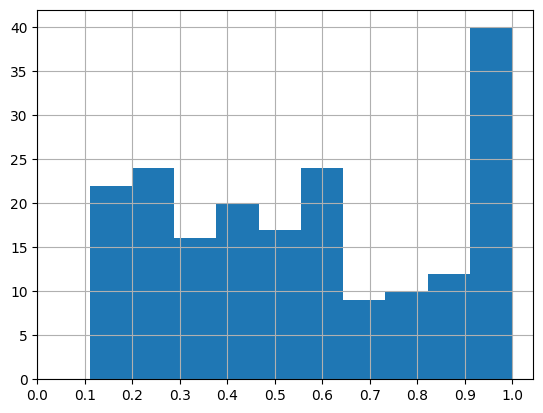

In [137]:
ax = swe_bench_verified[swe_bench_verified['difficulty_encoded'] == 0]['empiric_difficulty'].hist()
ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

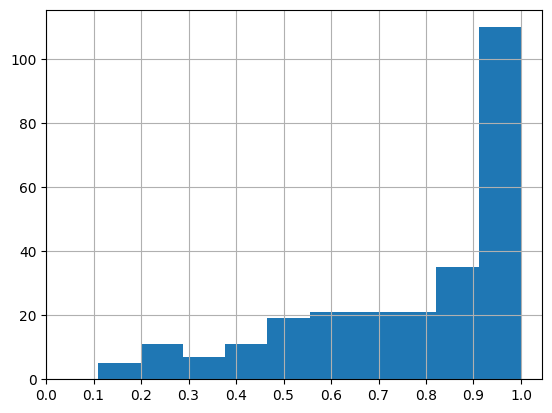

In [138]:
ax = swe_bench_verified[swe_bench_verified['difficulty_encoded'] == 1]['empiric_difficulty'].hist()
ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

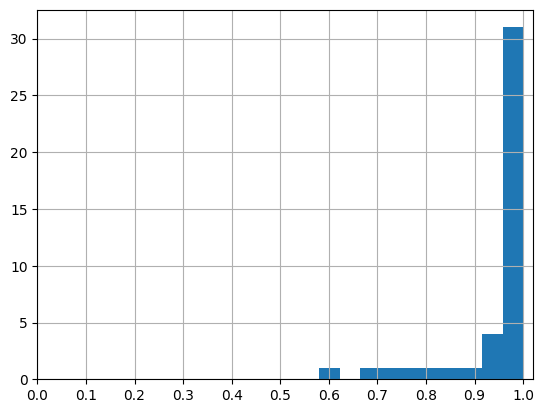

In [139]:
ax = swe_bench_verified[swe_bench_verified['difficulty_encoded'] == 2]['empiric_difficulty'].hist()
ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

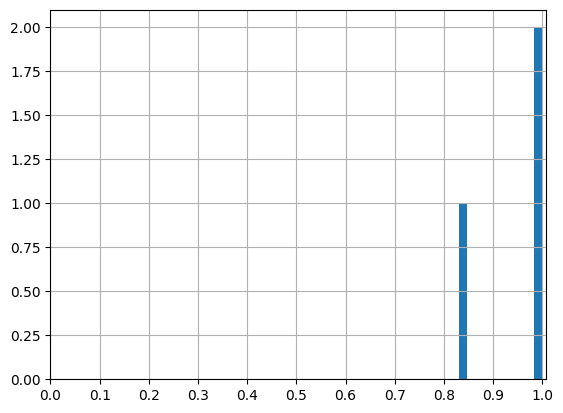

In [140]:
ax = swe_bench_verified[swe_bench_verified['difficulty_encoded'] == 3]['empiric_difficulty'].hist()
ax.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

In [ ]:
# TODO: Turn this into a nice plot of four subplots that I can potentially use in my paper/report

In [142]:
swe_bench_verified[swe_bench_verified['difficulty_encoded'] == 1].sort_values(by=['empiric_difficulty'], ascending=False)[['instance_id','empiric_difficulty', 'difficulty']]

,instance_id,empiric_difficulty,difficulty
281,matplotlib__matplotlib-25960,1.00,15 min - 1 hour
230,django__django-16502,1.00,15 min - 1 hour
117,django__django-13513,1.00,15 min - 1 hour
186,django__django-15280,1.00,15 min - 1 hour
189,django__django-15375,1.00,15 min - 1 hour
...,...,...,...
72,django__django-12143,0.17,15 min - 1 hour
350,scikit-learn__scikit-learn-10844,0.14,15 min - 1 hour
231,django__django-16527,0.14,15 min - 1 hour
123,django__django-13658,0.14,15 min - 1 hour
